# 0.0.IMPORTS

In [1]:
import pandas            as pd
import seaborn           as sns
import scikitplot        as skplt
import matplotlib.pyplot as plt
import sweetviz          as sv
import numpy             as np
import lightgbm          as lgb

import random
import inflection
import os
import warnings
import pickle


from sklearn import preprocessing    as pp
from sklearn import model_selection  as ms
from sklearn import ensemble         as en
from sklearn import linear_model     as lm
from sklearn import neighbors        as nh
from scipy   import stats            as ss
from pathlib import Path




from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV
from skopt.space             import Real, Categorical, Integer
from bask                    import BayesSearchCV
from skopt                   import gp_minimize
from IPython.core.display    import HTML
from sklearn.metrics import make_scorer


C:\Users\nerod\anaconda3\envs\Health_Insurance\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 0.1. Helper Function

In [2]:
def cross_validation( x_train, y_train, n_splits, model, name_model):
    
    kf = KFold(n_splits=n_splits)
    x_group = x_train.copy()
    x_group['response'] = y_train.copy()
    
    group_precision = []
    group_recall = []
    
    for train_idx, test_idx in kf.split(x_group):
        X_train_2 = x_group.iloc[train_idx]
        X_test_2 = x_group.iloc[test_idx]
        y_train_3 = X_train_2['response'].copy()
        y_test_3 = X_test_2['response'].copy()
        X_train_3 = X_train_2.drop('response', axis=1)
        X_test_3 = X_test_2.drop('response', axis=1)
        
        m = model.fit(X_train_3, y_train_3)
    
       # model prediction
        yhat = m.predict_proba( X_test_3 )
    
        df8_metric = X_test_2.copy()
        
        # propensity score
        df8_metric['score'] = yhat[:,1].tolist()
        # sorte clients by propensity score
        df8_metric = df8_metric.sort_values('score', ascending = False)
    
        precision_at_ = precision_at_k( df8_metric, k=20000 )
        
        recall_at_ = recall_at_k( df8_metric, k=20000 )
        
        group_precision.append(precision_at_)
        group_recall.append(recall_at_)
        
        avg_precision_at_k = np.mean(group_precision)
        avg_recall_at_k    = np.mean(group_recall)
        
    return pd.DataFrame({'Model name':name_model, 
                        'precision_at_k': avg_precision_at_k, 
                        'recall_at_k':avg_recall_at_k}, index=[0])


def precision_at_k( data, k=2000 ):
    #reset index
    data = data.reset_index( drop=True )
    
    # create ranking order
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

def recall_at_k( data, k=2000 ):
    #reset index
    data = data.reset_index( drop=True )
    
    # create ranking order
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

def type_NA(data):
    type_data = data.dtypes
    sum_na    = data.isna().sum()
    per_na    = data.isna().mean()
    
    metrics = pd.DataFrame({'Type':type_data, 'number na': sum_na, 'percent na':per_na})
    
    return metrics

def statistics_info(data):

    num_data = data.select_dtypes(include=['int', 'float'])

    # Central Tendency
    mean = num_data.apply(np.mean)
    q50 = num_data.quantile(0.5)

    # quantiles
    q25 = num_data.quantile(0.25)
    q50 = num_data.quantile(0.5)
    q75 = num_data.quantile(0.75)

    range_ = num_data.apply(lambda x: x.max() - x.min())
    count = num_data.count()

    # Dispersion
    min_ = num_data.apply(min)
    max_ = num_data.apply(max)
    std = num_data.apply(np.std)


    skew = num_data.apply(lambda x: x.skew())
    kurtosis = num_data.apply(lambda x: x.kurtosis())


    metrics = pd.DataFrame({'min': min_,'max':max_, 'range': range_ , 'quant25': q25, 'median':q50, 'quant75': q75,
                            'mean':mean, 'std':std,'skew':skew,'kurtosis':kurtosis,'Non-Null': count,})
    
    return (np.round(metrics,1))


def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1)*(r - 1) / (n - 1))
    
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (k - 1)**2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1))) 



def jupyter_settings():
    %matplotlib inline
#    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 7]
#    plt.rcParams['font.size'] = 10
    sns.set(font_scale=2)

#    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [3]:
def make_score( y_true, yhat_model):
    # copy data
    data = pd.DataFrame(y_true)

    # propensity score
    data['score'] = yhat_model[:,1].tolist()

    # sorted clients by propensity score
    data = data.sort_values('score', ascending=False)
    data = data.reset_index( drop=True )
    
    data['ranking'] = np.arange(1, len(data)+1, 1)
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    percents = np.arange(0.05, 1.05, 0.05)
    k_list = []
    for i in percents:
        k = int(len(data)*i) - 1
        k_list.append( k )
    
    data = data.loc[k_list, ['score', 'precision_at_k', 'recall_at_k']]
    data['k'] = percents
    data = data[['k', 'precision_at_k', 'recall_at_k', 'score']]
    data = data.reset_index(drop=True)
    
    return data

In [4]:
def cat_features( data ):
    cat_attributes = data.select_dtypes(exclude=['int', 'float', 'datetime64[ns]'])

    for col in cat_attributes.columns:
        fig, ax = plt.subplots()
        sns.countplot( x=col, data=cat_attributes, ax=ax)
        ax.set_title("CountPlot " + col, fontsize=10)
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width()/2., height + 3, '{:.1f}%'.format(height/len(cat_attributes)*100), ha="center")
    
    return None

In [5]:
jupyter_settings()

# 0.1 Business search

## 0.1.1. Cross Selling Search

The cross-sell strategy is a marketing and sales approach that aims to offer complementary products or services to customers, based on their previous purchases or preferences. Not only does this increase revenue from the current sale, but it can also improve customer satisfaction as they realize that the company is meeting their needs and offering comprehensive solutions.

Sources:

https://blog.e-goi.com/br/cross-selling/

https://www.zendesk.com.br/blog/cross-sell/

# 0.2. Loading ddata

In [6]:
user_profile = os.environ['USERPROFILE']
project_folder = 'Repos\\DS\\PA004\\health_insurance_cross-sell\\data\\raw'
file_name = 'train.csv'
report_relative_path = 'reports\\sweetviz_customer_info.html'


file_path = os.path.join(user_profile, project_folder, file_name)
file_path_othres = os.path.join(user_profile, project_folder,report_relative_path)

In [7]:
df_raw = pd.read_csv(file_path, low_memory=False)


In [8]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 0.3 Data Split

In [9]:
# Spliting Data
train_model, test_model = ms.train_test_split( df_raw, train_size=0.80, test_size=0.20, random_state=0, stratify=df_raw['Response'], shuffle=True)

train_model.shape, test_model.shape

((304887, 12), (76222, 12))

In [10]:
df1 = train_model.copy()

In [65]:
test_data = test_model.copy()
test_api = test_model.copy()

In [12]:
test_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
339281,339282,Female,26,1,41.0,0,< 1 Year,No,37527.0,152.0,216,0
150863,150864,Female,22,1,22.0,1,< 1 Year,No,27379.0,152.0,73,0
378804,378805,Female,42,1,48.0,1,1-2 Year,No,2630.0,26.0,92,0
79349,79350,Male,54,1,28.0,0,1-2 Year,Yes,69990.0,26.0,168,0
93592,93593,Male,55,1,3.0,0,1-2 Year,Yes,26316.0,119.0,142,0


# 1.0. Description of the data

## 1.1. Description of the columns

| Command | Description | Translation |
| --- | --- | --- |
| id | Unique ID for the customer | ID exclusivo para o cliente |
| Gender | Gender of the customer | Sexo do cliente |
| Age | Age of the customer | Idade do cliente |
| Driving_License | 0 : Customer does not have DL, 1 : Customer already has DL | 0 : O cliente não tem DL, 1 : O cliente já tem DL |
| Region_Code | Unique code for the region of the customer | Código exclusivo para a região do cliente |
| Previously_Insured | 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance | 1 : Cliente já tem Seguro de Veículo, 0 : Cliente não tem Seguro de Veículo |
| Vehicle_Age | Age of the Vehicle | Idade do Veículo |
| Vehicle_Damage | 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past. | 1 : Cliente teve seu veículo danificado no passado. 0 : O cliente não teve seu veículo danificado no passado. |
| Annual_Premium | The amount customer needs to pay as premium in the year | O valor que o cliente precisa pagar como prêmio no ano |
| Policy_Sales_Channel | Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc. | Código anonimizado para o canal de contato com o cliente ou seja. Agentes diferentes, por correio, por telefone, pessoalmente, etc. |
| Vintage | Number of Days, Customer has been associated with the company | Número de Dias, o Cliente foi associado à empresa |
| Response | 1 : Customer is interested, 0 : Customer is not interested | 1 : O cliente está interessado, 0 : O cliente não está interessado |



## 1.1.1 Hypotheses

H1: Pessoas com idade acima de 40 anos contratam mais seguros.

H2: Homens contratam mais seguros do que as mulheres.

H3: Clientes que já tem seguros não tem interesse na oferta.

## 1.2. Rename Columns

In [13]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore(x)
cols_new = list( map(snakecase, cols_old) )

df1.columns = cols_new

In [14]:
df1.head(10)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
135702,135703,Female,45,1,28.0,1,1-2 Year,No,38572.0,124.0,112,0
99684,99685,Male,23,1,39.0,1,< 1 Year,No,32497.0,152.0,131,0
47099,47100,Female,44,1,46.0,0,1-2 Year,Yes,25113.0,26.0,169,0
359154,359155,Female,23,1,41.0,0,< 1 Year,Yes,39038.0,152.0,259,0
21795,21796,Male,44,1,8.0,1,1-2 Year,No,27164.0,26.0,130,0
356149,356150,Female,73,1,28.0,0,1-2 Year,Yes,92985.0,122.0,194,0
291046,291047,Female,21,1,28.0,0,< 1 Year,Yes,38588.0,154.0,13,0
120684,120685,Female,29,1,7.0,1,< 1 Year,No,25364.0,152.0,248,0
377941,377942,Male,21,1,7.0,1,< 1 Year,No,2630.0,160.0,79,0
22304,22305,Male,27,1,18.0,1,< 1 Year,No,46921.0,152.0,53,0


## 1.2. Data Dimensions

In [215]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of columns {}'.format(df1.shape[1]))

Number of Rows: 304887
Number of columns 12


## 1.3. Data types and check NA

In [216]:
m = type_NA(df1)
m

,Type,number na,percent na
id,int64,0,0.0
gender,object,0,0.0
age,int64,0,0.0
driving_license,int64,0,0.0
region_code,float64,0,0.0
previously_insured,int64,0,0.0
vehicle_age,object,0,0.0
vehicle_damage,object,0,0.0
annual_premium,float64,0,0.0
policy_sales_channel,float64,0,0.0


## 1.5. Fillout NA

## 1.6. Change type

## 1.7. Descriptive Statistical

In [66]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

In [67]:
des_num = statistics_info(df1)

In [68]:
des_num

,min,max,range,quant25,median,quant75,mean,std,skew,kurtosis,Non-Null
id,1.0,381109.0,381108.0,95387.5,190446.0,285784.0,190541.0,109994.3,0.0,-1.2,304887
age,20.0,85.0,65.0,25.0,36.0,49.0,38.8,15.5,0.7,-0.6,304887
driving_license,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-21.2,449.4,304887
region_code,0.0,52.0,52.0,15.0,28.0,35.0,26.4,13.2,-0.1,-0.9,304887
previously_insured,0.0,1.0,1.0,0.0,0.0,1.0,0.5,0.5,0.2,-2.0,304887
annual_premium,2630.0,540165.0,537535.0,24405.0,31673.0,39399.0,30554.7,17160.8,1.7,32.8,304887
policy_sales_channel,1.0,163.0,162.0,29.0,133.0,152.0,112.1,54.2,-0.9,-1.0,304887
vintage,10.0,299.0,289.0,82.0,154.0,227.0,154.3,83.7,0.0,-1.2,304887
response,0.0,1.0,1.0,0.0,0.0,0.0,0.1,0.3,2.3,3.3,304887


# 2.0. Feature Engineering

In [15]:
df2 = df1.copy()

In [16]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year'
                                             if x == '1-2 Year' else 'below_1_year')

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x =='Yes' else 0)



# 3.0. Data Filtering

In [17]:
df3 = df2.copy()

# 4.0.EDA

In [18]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Target

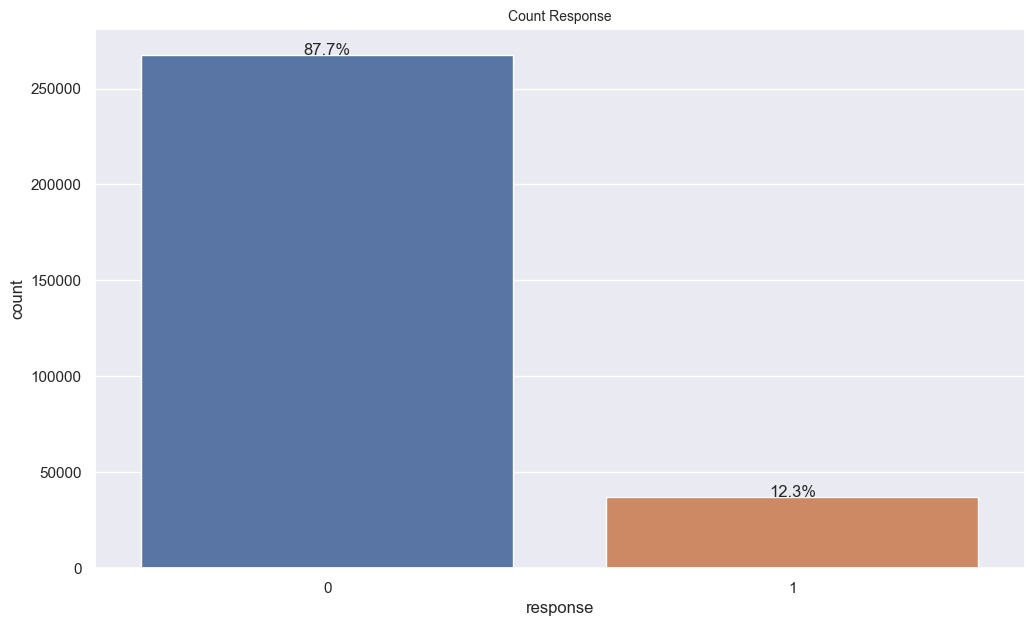

In [22]:
fig, ax = plt.subplots()
sns.countplot(data=df4, x='response', ax=ax)
ax.set_title("Count Response", fontsize=10)



for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3, '{:.1f}%'.format(height/len(df2)*100), ha="center")

### 4.1.2. Numeric Attibutes

C:\Users\nerod\AppData\Local\Temp\ipykernel_5864\2533347166.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df4.hist(ax=ax, bins= 10);


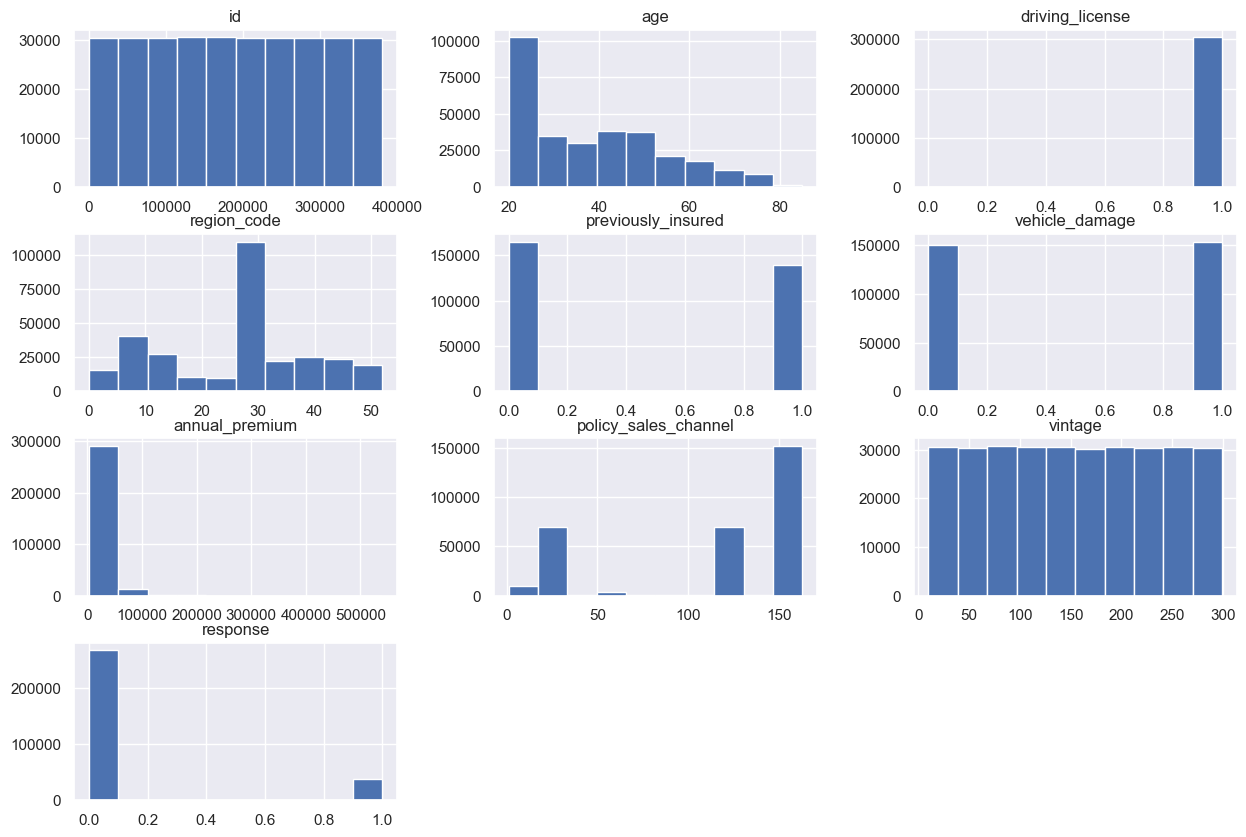

In [23]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
df4.hist(ax=ax, bins= 10);

### 4.1.3. Categorical Attibutes

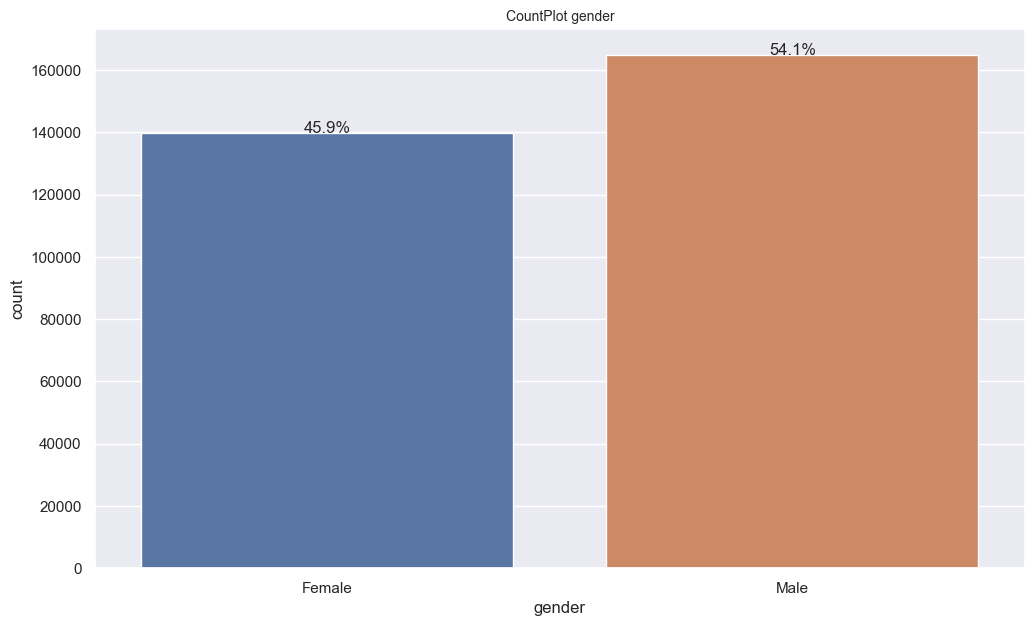

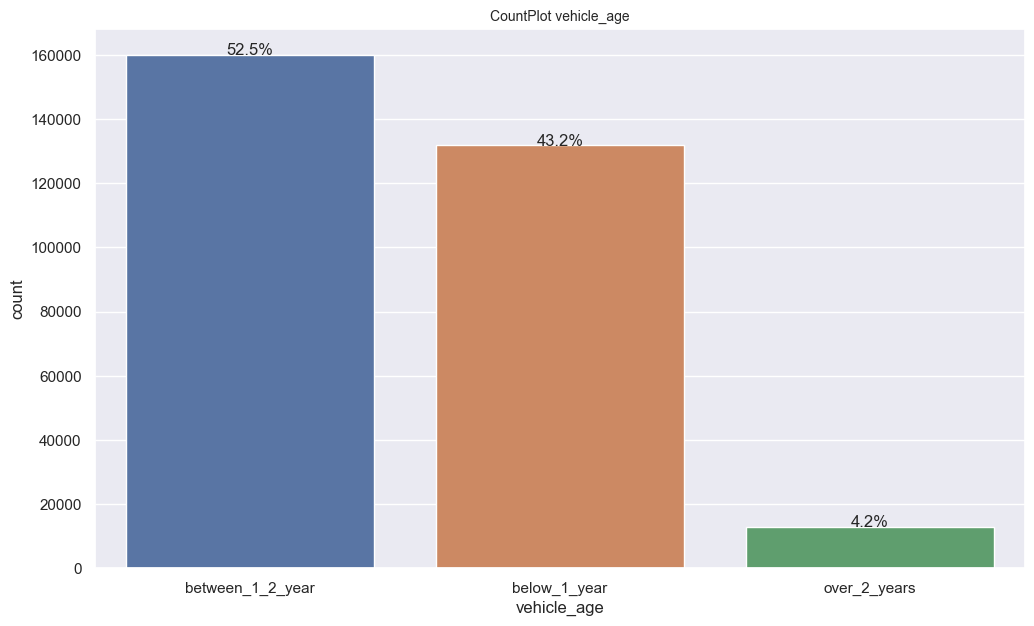

In [24]:
cat_features(df4)

* das

## 4.2. Bivariate Analysis

### 4.2.1 Viewing with SweetViz

In [64]:
# Report generation

#sweetviz_report = sv.analyze(df4, target_feat="response")
#sweetviz_report.show_html(filepath=file_path_othres,open_browser=False);

C:\Users\nerod\anaconda3\envs\Health_Insurance\lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
C:\Users\nerod\anaconda3\envs\Health_Insurance\lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: response (TARGET)                   |▊         | [  8%]   00:00 -> (00:03 left)C:\Users\nerod\anaconda3\envs\Health_Insurance\lib\site-packages\sweetviz\series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
Feature: id                                  |█▌        | [ 15%]   00:00 -> (00:02 left)C:\Us

Report C:\Users\nerod\Repos\DS\PA004\health_insurance_cross-sell\data\reports\sweetviz_customer_info.html was generated.


### 4.2.2 Hypothesis

#### H1: People over the age of 40 are more likely to take out vehicle insurance.

<font color="blue"> True: People over the age of 40 are more likely to take out insurance. It was verified that 63.22% of the people who said they were interested in hiring the insurance were aged 40 years or older. </font>

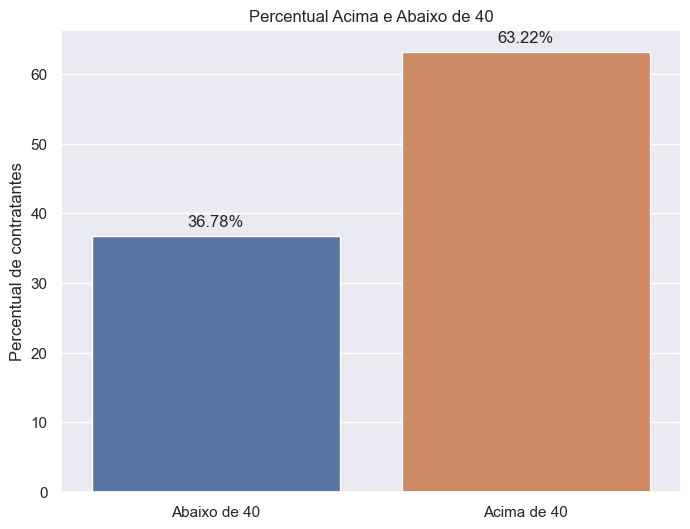

In [25]:
Valor_ref = 40
percentual_acima_40 = len(df4.loc[(df4['age']>=Valor_ref) & (df4['response']==1),'age'])/len(df4.loc[df4['response']==1,'age'])*100
percentual_abaixo_40 = len(df4.loc[(df4['age']<Valor_ref) & (df4['response']==1),'age'])/len(df4.loc[df4['response']==1,'age'])*100

plt.figure(figsize=(8,6))
ax = sns.barplot(x=['Abaixo de 40','Acima de 40'],y=[percentual_abaixo_40,percentual_acima_40], palette='deep')

plt.ylabel('Percentual de contratantes')
plt.title(f'Percentual Acima e Abaixo de {Valor_ref}')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

#### H2: Men hire safer than women.
<font color="blue"> True: Men are more likely to buy car insurance than women. Men are more likely to buy car insurance than women. Around 61,2% of the base who answered yes were men. </font>

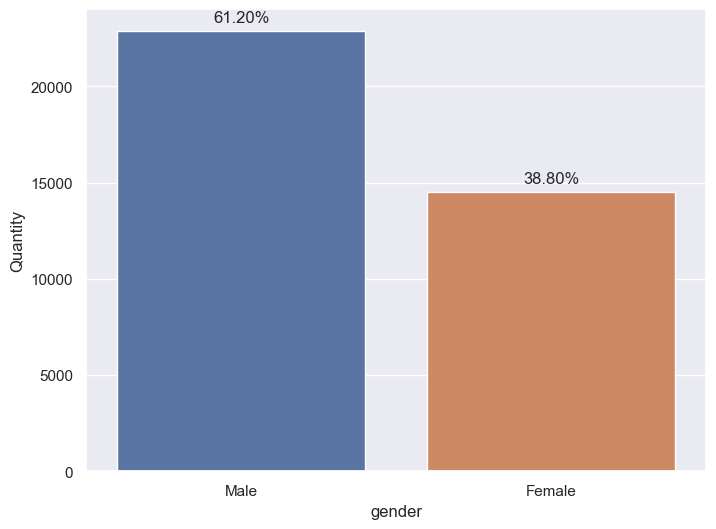

In [26]:
aux1 = df4.loc[df4['response']==1,'gender']
plt.figure(figsize=(8,6))
ax = sns.countplot(x=aux1, palette='deep')

plt.ylabel('Quantity')

total = float(len(aux1))
for p in ax.patches:
        ax.annotate(f'{(p.get_height()/total)*100:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


#### H3: Most customers who have an interest in the offer do not have insurance
<font color="blue"> True: More than 99% of people who were classified as interested do not have vehicle insurance. </font>

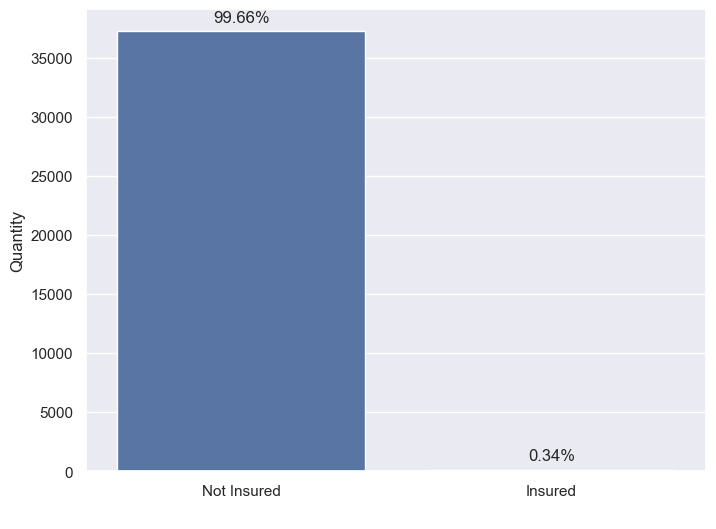

In [27]:
aux1 = df4.loc[df4['response']==1,'previously_insured']

plt.figure(figsize=(8,6))
ax = sns.countplot(x=aux1, palette='deep')
ax.set_xticklabels(['Not Insured', 'Insured'])

plt.ylabel('Quantity')
plt.xlabel(' ')


total = float(len(aux1))
for p in ax.patches:
        ax.annotate(f'{(p.get_height()/total)*100:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

#### H4: The search for insurance is higher for customers with newer cars.
<font color="blue"> False: The demand occurs for vehicles aged 1 to 2 years. In relation to the database, this time is considered "median". The period of 1 to 2 years concentrates 74% of those interested </font>

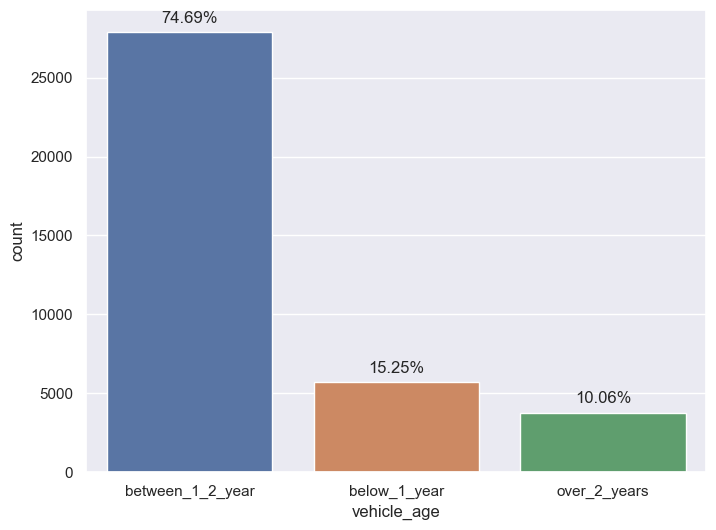

In [28]:
aux1 = df4.loc[df4['response']==1,'vehicle_age']

plt.figure(figsize=(8,6))
ax = sns.countplot(x=aux1, palette='deep')

total = float(len(aux1))
for p in ax.patches:
        ax.annotate(f'{(p.get_height()/total)*100:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

## 4.3. Multivariate Analysis

<Axes: >

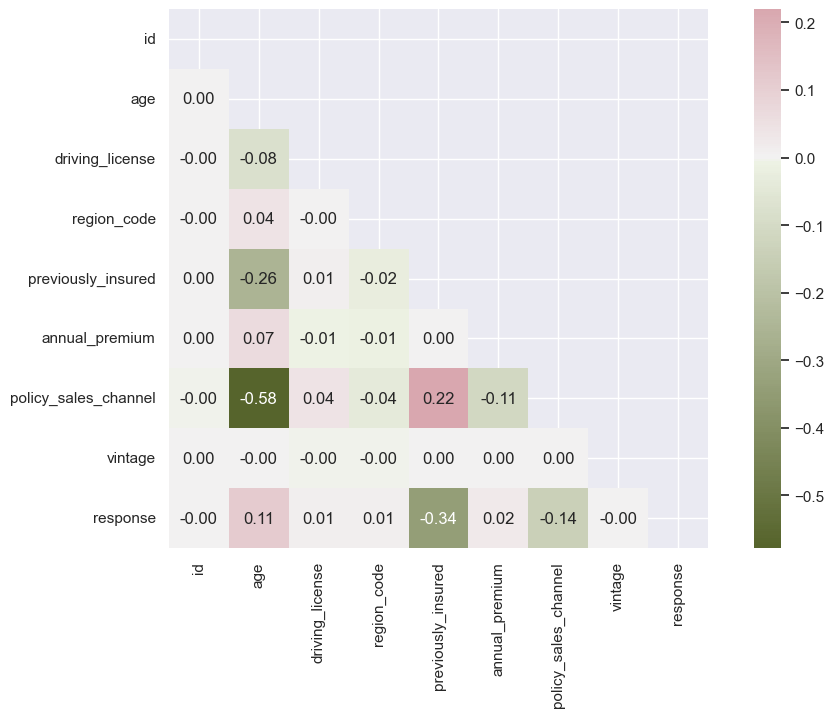

In [29]:
correlation = num_attributes.corr( method='pearson')
#sns.heatmap(correlation, annot=True);


mask = np.triu(np.ones_like(correlation, dtype=bool))
cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)
sns.heatmap(correlation, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)

<Axes: >

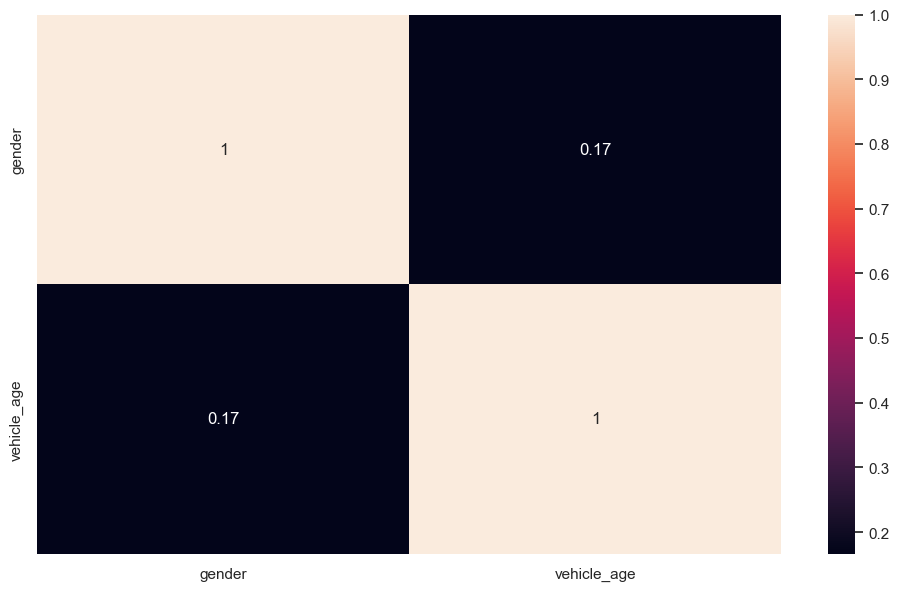

In [21]:
a = df4.select_dtypes( include='object' )
# Calculate cramer V

a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )
a3 = cramer_v( a['vehicle_age'], a['gender'] )
a4 = cramer_v( a['vehicle_age'], a['vehicle_age'] )

d = pd.DataFrame( {'gender': [a1, a2],
'vehicle_age': [a3, a4]})

d = d.set_index( d.columns )


sns.heatmap( d, annot=True )


# 5.0. Data preparation

In [37]:
x = df4.drop( 'response', axis=1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( x, y, test_size=0.20, random_state=0, stratify=y, shuffle=True)

df5 = pd.concat( [x_train, y_train], axis=1)


In [138]:
#df5 = df5.drop('response', axis=1)
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
291679,291680,0.458864,0.323077,1,0.005149,1,0,-1.627171,0.194355,0.301038,0,0,1,0
230758,230759,0.541136,0.276923,1,0.035013,1,0,0.153712,0.208164,0.899654,0,0,1,0
264520,264521,0.458864,0.230769,1,0.088882,1,0,0.275718,0.194355,0.422145,0,0,1,0
40583,40584,0.541136,0.092308,1,0.019577,1,0,-0.107073,0.354501,0.989619,0,1,0,0
348206,348207,0.541136,0.800000,1,0.014694,0,1,-0.329305,0.208164,0.190311,0,0,1,0


## Standardization

In [39]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values)


pickle.dump(ss, open('C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\features\\annual_premium_scaler.pkl','wb'))

## Rescaling

In [40]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values)
pickle.dump(mms_age, open('C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\features\\age_scaler.pkl','wb'))


# Vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values)
pickle.dump(mms_vintage, open('C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\features\\vintage_scaler.pkl','wb'))


## Encoder

In [192]:
## gender - One Hot Encoding
#target_encode_gender = df5.groupby('gender')['response'].mean()
#df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
#pickle.dump(target_encode_gender, open('C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\features\\target_encode_gender_scaler.pkl','wb'))
#
#
### region_code-> Target Encoding
#target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
#df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
#pickle.dump(target_encode_region_code, open('C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\features\\target_encode_region_code_scaler.pkl','wb'))
#
##
### vehicle_age -> One Hot Encoding
#df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'])
##
### policy_sales_channel -> Frequency Encoding
#fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len(df5)
#df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
#
#pickle.dump(fe_policy_sales_channel, open('C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\features\\fe_policy_sales_channel_scaler.pkl','wb'))
#



C:\Users\nerod\AppData\Local\Temp\ipykernel_9096\2139780859.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )


In [24]:
target_encode_gender = df5.groupby('gender')['response'].mean()
target_encode_gender

gender
Female    0.103796
Male      0.138475
Name: response, dtype: float64

In [247]:
df5.head()

In [35]:

target_encode_gender = df5['gender'].value_counts(normalize=True)
target_encode_gender

Male      0.541136
Female    0.458864
Name: gender, dtype: float64

In [41]:
# gender - One Hot Encoding
target_encode_gender = df5['gender'].value_counts(normalize=True)
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump(target_encode_gender, open('C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\features\\target_encode_gender_scaler.pkl','wb'))


## region_code-> Target Encoding
target_encode_region_code = df5['region_code'].value_counts(normalize=True)
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump(target_encode_region_code, open('C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\features\\target_encode_region_code_scaler.pkl','wb'))

#
## vehicle_age -> One Hot Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'])
#
## policy_sales_channel -> Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

pickle.dump(fe_policy_sales_channel, open('C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\features\\fe_policy_sales_channel_scaler.pkl','wb'))


C:\Users\nerod\AppData\Local\Temp\ipykernel_16728\1100437050.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )


In [42]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
291679,291680,0.458864,0.323077,1,0.005149,1,0,-1.627171,0.194355,0.301038,0,0,1,0
230758,230759,0.541136,0.276923,1,0.035013,1,0,0.153712,0.208164,0.899654,0,0,1,0
264520,264521,0.458864,0.230769,1,0.088882,1,0,0.275718,0.194355,0.422145,0,0,1,0
40583,40584,0.541136,0.092308,1,0.019577,1,0,-0.107073,0.354501,0.989619,0,1,0,0
348206,348207,0.541136,0.800000,1,0.014694,0,1,-0.329305,0.208164,0.190311,0,0,1,0


## 5.4 Validation Preparation

In [43]:
x_validation[x_validation.columns[1]] = x_validation['gender'].map( target_encode_gender )

x_validation['age'] = mms_age.transform( x_validation[['age']].values)
#
x_validation.loc[:, 'region_code'] = x_validation['region_code'].map( target_encode_region_code )
#
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'])
#
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values)
#
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )
#
x_validation['vintage'] = mms_vintage.transform( x_validation[['vintage']].values)

#
x_validation = x_validation.fillna( 0 )

In [44]:
x_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
165497,165498,0.541136,0.369231,1,0.010582,0,1,0.238563,0.208164,0.041522,0,1,0
329198,329199,0.541136,0.400000,1,0.024070,1,0,-0.459930,0.194355,0.688581,0,1,0
20507,20508,0.541136,0.046154,1,0.002124,1,0,-0.055941,0.354501,0.975779,1,0,0
241906,241907,0.458864,0.015385,1,0.026534,1,0,-0.268797,0.354501,0.242215,1,0,0
248689,248690,0.458864,0.261538,1,0.031844,1,0,-0.363373,0.354501,0.636678,0,1,0


In [45]:
x_validation.isna().sum()

id                              0
gender                          0
age                             0
driving_license                 0
region_code                     0
previously_insured              0
vehicle_damage                  0
annual_premium                  0
policy_sales_channel            0
vintage                         0
vehicle_age_below_1_year        0
vehicle_age_between_1_2_year    0
vehicle_age_over_2_years        0
dtype: int64

# 6.0. Feature Selection

In [47]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1)
y_train_n = y_train.values

forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.271429
0                annual_premium    0.242419
0                           age    0.172814
0                   region_code    0.099326
0                vehicle_damage    0.068458
0          policy_sales_channel    0.061721
0            previously_insured    0.055729
0      vehicle_age_below_1_year    0.013502
0  vehicle_age_between_1_2_year    0.007015
0                        gender    0.004877
0      vehicle_age_over_2_years    0.002163
0               driving_license    0.000547


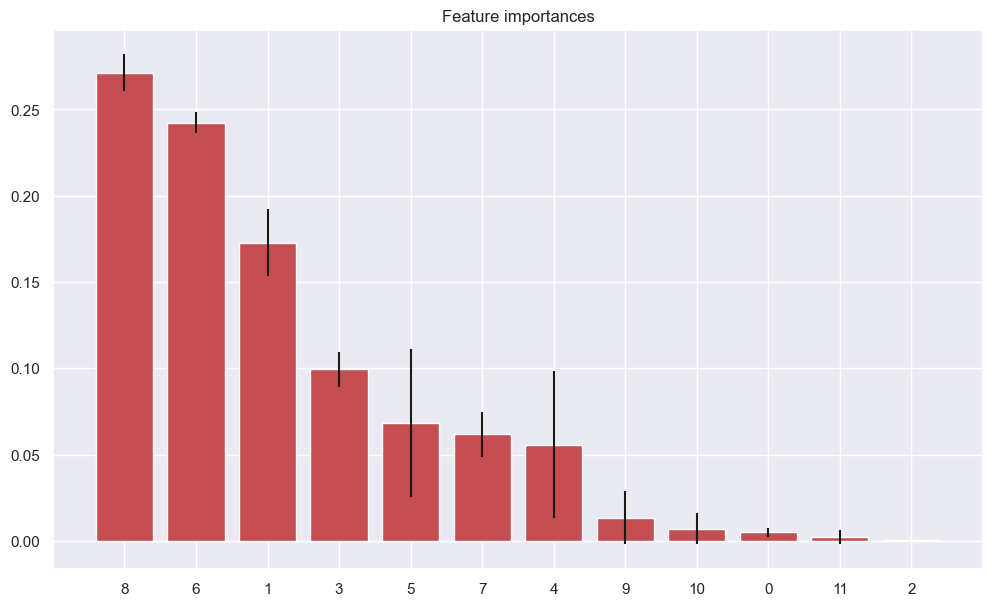

In [48]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0])
    df = pd.concat( [df, aux], axis=0 )

print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()


# 7.0 Select model and Hyperparameters

In [49]:
cols_selected = ['vintage' , 'annual_premium', 'age', 'region_code' ,'vehicle_damage' , 'policy_sales_channel','previously_insured']

x_train = df5[cols_selected]
x_val   = x_validation[cols_selected]
y_val = y_validation.copy()

In [50]:
x_val.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
165497,0.041522,0.238563,0.369231,0.010582,1,0.208164,0
329198,0.688581,-0.459930,0.400000,0.024070,0,0.194355,1
20507,0.975779,-0.055941,0.046154,0.002124,0,0.354501,1
241906,0.242215,-0.268797,0.015385,0.026534,0,0.354501,1
248689,0.636678,-0.363373,0.261538,0.031844,0,0.354501,1


## 8.1 Bayesian search (with bask.BayesSearchCV)

### 8.1 KNN

In [124]:
params = {'n_neighbors':Integer(3, 12),
          'weights':['uniform', 'distance']
        }
model = nh.KNeighborsClassifier()

In [125]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [126]:
bayes_search = BayesSearchCV( model, params, cv=stratified_kfold, n_iter=20,  n_jobs=-1)

C:\Users\nerod\anaconda3\envs\Health_Insurance\lib\site-packages\skopt\searchcv.py:300: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn("The `iid` parameter has been deprecated "


In [127]:
bayes_search.fit(x_train, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=KNeighborsClassifier(), n_iter=20, n_jobs=-1,
              optimizer_kwargs={'acq_func': 'pvrs'},
              search_spaces={'n_neighbors': Integer(low=3, high=12, prior='uniform', transform='normalize'),
                             'weights': ['uniform', 'distance']})

In [128]:
pd.DataFrame(list(bayes_search.best_params_.items()), columns=['Parameter', 'Value'])

,Parameter,Value
0,n_neighbors,12
1,weights,uniform


In [129]:
bayes_search.best_score_

0.871898948935416

In [55]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=12, weights='uniform' )

# model training
knn_model.fit(x_train, y_train)

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

In [56]:
make_score(y_val, yhat_knn)

,k,precision_at_k,recall_at_k,score
0,0.05,0.341207,0.139149,0.416667
1,0.10,0.330818,0.269869,0.416667
2,0.15,0.320577,0.392293,0.333333
3,0.20,0.312997,0.510704,0.250000
4,0.25,0.303136,0.618277,0.250000
5,0.30,0.293172,0.717554,0.166667
6,0.35,0.282495,0.806663,0.166667
7,0.40,0.268255,0.875435,0.083333
8,0.45,0.253535,0.930827,0.083333
9,0.50,0.232805,0.949692,0.000000


### 8.2 Logistic regression

In [113]:
params = {'C':Real(0, 15),
          'solver':['newton-cg', 'lbfgs', 'sag', 'saga']
        }
model_lr = lm.LogisticRegression()
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [106]:
bayes_search_log = BayesSearchCV( model_lr, params, cv=stratified_kfold, n_iter=20,  n_jobs=-1)

C:\Users\nerod\anaconda3\envs\Health_Insurance\lib\site-packages\skopt\searchcv.py:300: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn("The `iid` parameter has been deprecated "


In [114]:
bayes_search_log.fit(x_train, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=LogisticRegression(), n_iter=20, n_jobs=-1,
              optimizer_kwargs={'acq_func': 'pvrs'},
              search_spaces={'C': Real(low=0, high=25, prior='uniform', transform='normalize'),
                             'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']})

In [115]:
pd.DataFrame(list(bayes_search_log.best_params_.items()), columns=['Parameter', 'Value'])# 15

,Parameter,Value
0,C,17.323429
1,solver,saga


In [142]:
# model definition
lr_model = lm.LogisticRegression( C=17.323429, solver='saga', random_state=42, n_jobs=-1)

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

In [143]:
make_score(y_val, yhat_lr)

,k,precision_at_k,recall_at_k,score
0,0.05,0.262139,0.106904,0.306518
1,0.10,0.303756,0.247792,0.292340
2,0.15,0.311502,0.381188,0.285125
3,0.20,0.290365,0.473776,0.262029
4,0.25,0.287982,0.587370,0.238148
5,0.30,0.283223,0.693203,0.225505
6,0.35,0.277481,0.792347,0.214818
7,0.40,0.268870,0.877442,0.203490
8,0.45,0.258273,0.948220,0.188226
9,0.50,0.241169,0.983811,0.037871


## 8.3. LightGBM

In [144]:
params = {'boosting_type':['gbdt', 'dart', 'goss'],
          'max_depth':Integer(3, 11),
          'num_leaves':Integer(250, 400),
          'num_iterations':Integer(1000, 1500),
          'learning_rate':Real(0.001, 0.01)        
        }
lgbm_model = lgb.LGBMClassifier()
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [145]:
bayes_search_lgbm = BayesSearchCV( lgbm_model, params, cv=stratified_kfold, n_iter=10,  n_jobs=-1)

C:\Users\nerod\anaconda3\envs\Health_Insurance\lib\site-packages\skopt\searchcv.py:300: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn("The `iid` parameter has been deprecated "


In [146]:
bayes_search_lgbm.fit(x_train, y_train)

C:\Users\nerod\anaconda3\envs\Health_Insurance\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 29894, number of negative: 214015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122562 -> initscore=-1.968388
[LightGBM] [Info] Start training from score -1.968388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=LGBMClassifier(), n_iter=10, n_jobs=-1,
              optimizer_kwargs={'acq_func': 'pvrs'},
              search_spaces={'boosting_type': ['gbdt', 'dart', 'goss'],
                             'learning_rate': Real(low=0.001, high=0.01, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=11, prior='uniform', transform='normalize'),
                             'num_iterations': Integer(low=1000, high=1500, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=250, high=400, prior='uniform', transform='normalize')})

In [147]:
pd.DataFrame(list(bayes_search_lgbm.best_params_.items()), columns=['Parameter', 'Value'])

,Parameter,Value
0,boosting_type,gbdt
1,learning_rate,0.003622
2,max_depth,6
3,num_iterations,1109
4,num_leaves,318


In [148]:
# model definition
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=6, num_leaves=318, num_iterations=1109, learning_rate=0.003622, verbose=0)

# model training
lgbm_model.fit( x_train, y_train )

# model prediction
yhat_lgbm = lgbm_model.predict_proba( x_val )


C:\Users\nerod\anaconda3\envs\Health_Insurance\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [149]:
make_score(y_val, yhat_lgbm)

,k,precision_at_k,recall_at_k,score
0,0.05,0.416010,0.169655,0.364874
1,0.10,0.389372,0.317634,0.334052
2,0.15,0.368467,0.450896,0.313690
3,0.20,0.352194,0.574659,0.285342
4,0.25,0.334230,0.681697,0.257114
5,0.30,0.321270,0.786326,0.224030
6,0.35,0.303064,0.865400,0.178835
7,0.40,0.283465,0.925074,0.137341
8,0.45,0.262864,0.965079,0.091773
9,0.50,0.242448,0.989029,0.040366


## 8.0. Final Model

## 8.1 Training and validation concatenation

In [51]:
x_train_total = pd.concat( [x_train, x_val], axis=0)
y_train_total = pd.concat( [y_train, y_val], axis=0)


## 8.2 Final Model Training

In [154]:
# model definition
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=6, num_leaves=318, num_iterations=1109, learning_rate=0.003622, verbose=0)

# model training
lgbm_model.fit( x_train_total, y_train_total )
pickle.dump(lgbm_model, open('C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\models\\model_LGBM.pkl','wb'))


C:\Users\nerod\anaconda3\envs\Health_Insurance\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## 8.3 Test Base Preparation

### 8.3.1 Adjusting the Columns

In [155]:

test_data = test_data.rename(columns={'Response': 'response'})
test_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,response
339281,339282,Female,26,1,41.0,0,< 1 Year,No,37527.0,152.0,216,0
150863,150864,Female,22,1,22.0,1,< 1 Year,No,27379.0,152.0,73,0
378804,378805,Female,42,1,48.0,1,1-2 Year,No,2630.0,26.0,92,0
79349,79350,Male,54,1,28.0,0,1-2 Year,Yes,69990.0,26.0,168,0
93592,93593,Male,55,1,3.0,0,1-2 Year,Yes,26316.0,119.0,142,0


In [156]:
test_data_x = test_data.drop('response', axis=1)
test_data_y = test_data['response'].copy()

cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage']

snakecase = lambda x: inflection.underscore(x)
cols_new = list( map(snakecase, cols_old) )

test_data_x.columns = cols_new

# vehicle age
test_data_x['vehicle_age'] = test_data_x['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year'
                                             if x == '1-2 Year' else 'below_1_year')

# vehicle damage
test_data_x['vehicle_damage'] = test_data_x['vehicle_damage'].apply( lambda x: 1 if x =='Yes' else 0)

In [157]:
test_data_x.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
339281,339282,Female,26,1,41.0,0,below_1_year,0,37527.0,152.0,216
150863,150864,Female,22,1,22.0,1,below_1_year,0,27379.0,152.0,73
378804,378805,Female,42,1,48.0,1,between_1_2_year,0,2630.0,26.0,92
79349,79350,Male,54,1,28.0,0,between_1_2_year,1,69990.0,26.0,168
93592,93593,Male,55,1,3.0,0,between_1_2_year,1,26316.0,119.0,142


### 8.3.2 Data preparation

In [158]:
test_data_x[test_data_x.columns[1]] = test_data_x['gender'].map( target_encode_gender )

test_data_x['age'] = mms_age.transform( test_data_x[['age']].values)
#
test_data_x.loc[:, 'region_code'] = test_data_x['region_code'].map( target_encode_region_code )
#
test_data_x = pd.get_dummies( test_data_x, prefix='vehicle_age', columns=['vehicle_age'])
#
test_data_x.loc[:, 'annual_premium'] = ss.transform( test_data_x[['annual_premium']].values)
#
test_data_x.loc[:, 'policy_sales_channel'] = test_data_x['policy_sales_channel'].map( fe_policy_sales_channel )
#
test_data_x['vintage'] = mms_vintage.transform( test_data_x[['vintage']].values)

#
test_data_x = test_data_x.fillna( 0 )

In [159]:
test_data_x.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
339281,339282,0.458864,0.092308,1,0.047727,0,0,0.405120,0.354501,0.712803,1,0,0
150863,150864,0.458864,0.030769,1,0.003485,1,0,-0.185867,0.354501,0.217993,1,0,0
378804,378805,0.458864,0.338462,1,0.012218,1,0,-1.627171,0.208164,0.283737,0,1,0
79349,79350,0.541136,0.523077,1,0.279448,0,1,2.295662,0.208164,0.546713,0,1,0
93592,93593,0.541136,0.538462,1,0.024070,0,1,-0.247773,0.000295,0.456747,0,1,0


### 8.3.3. Select columns

In [160]:
cols_selected = ['vintage' , 'annual_premium', 'age', 'region_code' ,'vehicle_damage' , 'policy_sales_channel','previously_insured']

x_test_data = test_data_x[cols_selected].copy()
y_test_data = test_data_y.copy()

In [161]:
x_test_data.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
339281,0.712803,0.405120,0.092308,0.047727,0,0.354501,0
150863,0.217993,-0.185867,0.030769,0.003485,0,0.354501,1
378804,0.283737,-1.627171,0.338462,0.012218,0,0.208164,1
79349,0.546713,2.295662,0.523077,0.279448,1,0.208164,0
93592,0.456747,-0.247773,0.538462,0.024070,1,0.000295,0


### 8.3.4 Trained the model

In [162]:
# model prediction
yhat_lgbm_test = lgbm_model.predict_proba( x_test_data )

In [163]:
make_score(y_test_data, yhat_lgbm_test)

,k,precision_at_k,recall_at_k,score
0,0.05,0.406455,0.165810,0.359978
1,0.10,0.388350,0.316849,0.333986
2,0.15,0.368057,0.450439,0.310569
3,0.20,0.350564,0.572040,0.292393
4,0.25,0.336657,0.686684,0.256812
5,0.30,0.317677,0.777564,0.219023
6,0.35,0.299734,0.855920,0.174564
7,0.40,0.281521,0.918754,0.132975
8,0.45,0.262690,0.964462,0.094101
9,0.50,0.242135,0.987797,0.039171


<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

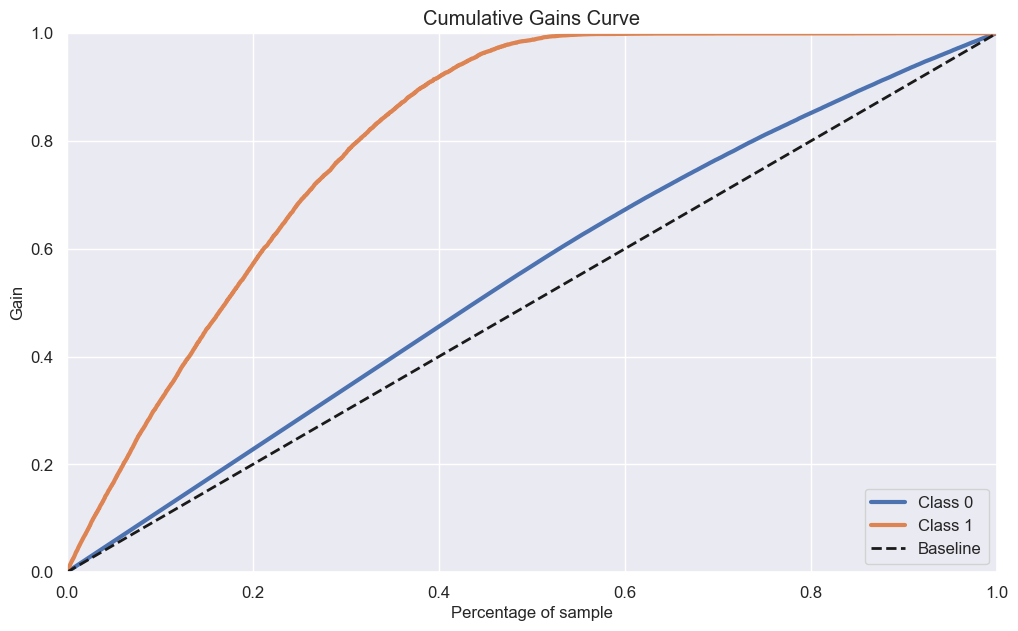

In [100]:
skplt.metrics.plot_cumulative_gain( y_test_data, yhat_lgbm_test)

According to the gain curve in relation to the chosen model, it shows that by selecting the top 20% of the new customer base, we would reach approximately ≈ 57% of those interested.

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

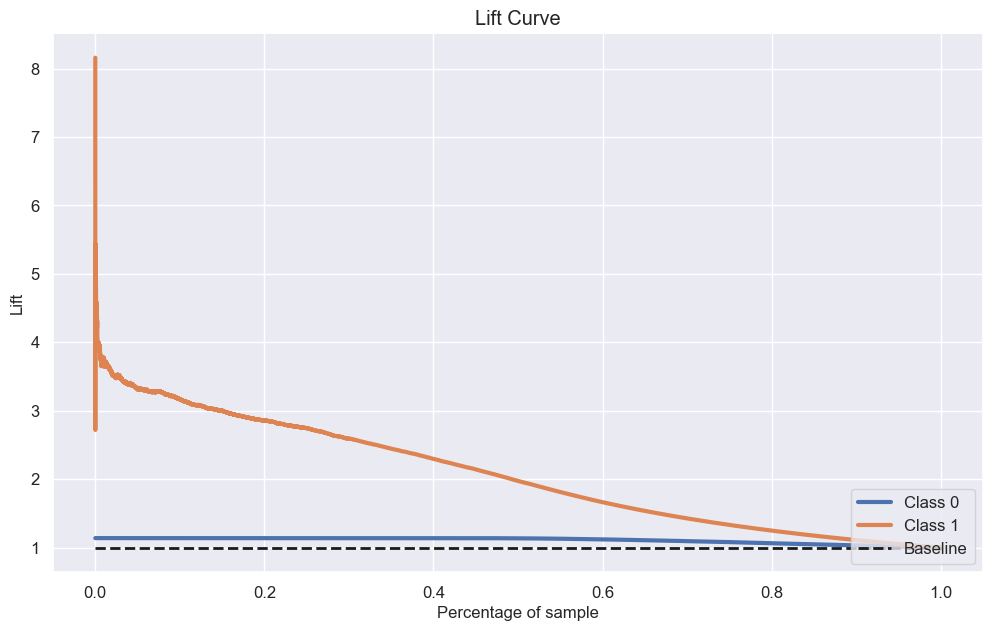

In [101]:
skplt.metrics.plot_lift_curve(  y_test_data, yhat_lgbm_test )

The lift curve demonstrates that in the top 20% of the new customer base (test) the model is ≈3 times better than the traditional model

## Deploy

In [165]:
import sys
sys.path.insert(0, 'C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\')

import pickle
import numpy as np
import pandas as pd
import inflection

class HealthInsurance:
    def __init__(self):
        self.home_path = 'C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\'
        self.annual_premium_scaler            =   pickle.load(open(self.home_path + 'features\\annual_premium_scaler.pkl', 'rb'))
        self.age_scaler                       =   pickle.load(open(self.home_path + 'features\\age_scaler.pkl','rb'))
        self.vintage_scaler                   =   pickle.load(open(self.home_path + 'features\\vintage_scaler.pkl','rb'))
        self.target_encode_gender_scaler      =   pickle.load(open(self.home_path + 'features\\target_encode_gender_scaler.pkl','rb'))
        self.target_encode_region_code_scaler =   pickle.load(open(self.home_path + 'features\\target_encode_region_code_scaler.pkl','rb'))
        self.fe_policy_sales_channel_scaler   =   pickle.load(open(self.home_path + 'features\\fe_policy_sales_channel_scaler.pkl','rb'))
        
    
    def data_cleaning(self, df1):
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage']

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list( map(snakecase, cols_old) )
        
        df3 = df1.copy()
        df3.columns = cols_new
        
        return df3
    
    def feature_engineering(self, df2):
        
        # vehicle age
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year'
                                             if x == '1-2 Year' else 'below_1_year')

        # vehicle damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x =='Yes' else 0)
        
        return df2
    
    def data_preparation(self, df5):
        
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values)
        
        # Age - MinMaxScaler        
        df5['age'] = self.age_scaler.transform( df5[['age']].values)

        # Vintage - MinMaxScaler
        df5['vintage'] =self.vintage_scaler.transform( df5[['vintage']].values)
        
        # Vintage - MinMaxScaler
        df5.loc[:, 'gender'] = df5['gender'].map(self.target_encode_gender_scaler)
                
        ## region_code-> Target Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code_scaler )
       
    
        ## vehicle_age -> One Hot Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'])
        
        
        ## policy_sales_channel -> Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel_scaler  )
        
        
        cols_selected = ['vintage' , 'annual_premium', 'age', 'region_code' ,'vehicle_damage' , 'policy_sales_channel','previously_insured']

        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # model prediction
        pred = model.predict_proba( test_data )
        
        
        # join predict into original data
        original_data['score'] = pred[:,1].tolist()
        
        return original_data.to_json( orient='records', date_format='iso')
        
        
        
        
        

## 8.2 API Handler

In [164]:
import sys
sys.path.insert(0, 'C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\') # Substitua pelo caminho real

import pickle
import pandas as pd
import numpy as np
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

path = 'C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\'

model = pickle.load( open(path + 'models\\model_LGBM.pkl','rb'))

app = Flask(__name__)

@app.route('/predict', methods=['POST'])

def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json:
        # unique example
        if isinstance( test_json, dict ): 
            test_raw = pd.DataFrame( test_json, index=[0] )
        # multiple example   
        else: 
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':   
   # app.run( '0.0.0.0')
    app.run( '0.0.0.0', debug=True )
    


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.100.7:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

C:\Users\nerod\anaconda3\envs\Health_Insurance\lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [104]:
from healthinsurance.HealthInsurance import HealthInsurance

In [125]:
import sys
sys.path.insert(0, 'C:\\Users\\nerod\\Repos\\DS\\PA004\\health_insurance_cross-sell\\')

In [123]:
from healthinsurance.HealthInsurance import HealthInsurance

In [128]:
jorge = HealthInsurance()

In [131]:
df_3_test = df_2_test.copy()

In [130]:
df_3_test.drop('Response', axis=1)

KeyError: "['Response'] not found in axis"

In [132]:
Return_1 = jorge.data_cleaning(df_3_test)

In [133]:
Return_2 = jorge.feature_engineering(Return_1)

In [134]:
Return_3 = jorge.data_preparation(Return_2)

C:\Users\nerod\AppData\Local\Temp\ipykernel_16728\1192140734.py:56: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df5.loc[:, 'gender'] = df5['gender'].map(self.target_encode_gender_scaler)


In [135]:
Return_3.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
321883,0.640138,0.155925,0.646154,0.279448,1,0.208164,1
306457,0.698962,1.085093,0.169231,0.279448,1,0.208164,0
231192,0.861592,-0.514556,0.553846,0.279448,1,0.208164,1
31554,0.671280,0.544830,0.630769,0.012214,1,0.208164,0
328918,0.249135,-0.090708,0.753846,0.007421,0,0.194355,1


In [136]:
return_4 = jorge.get_prediction(lgbm_model, df_3_test, Return_3)

In [137]:
return_4

'[{"id":321884,"Gender":"Male","Age":62,"Driving_License":1,"Region_Code":28.0,"Previously_Insured":1,"Vehicle_Age":"1-2 Year","Vehicle_Damage":"Yes","Annual_Premium":33248.0,"Policy_Sales_Channel":26.0,"Vintage":195,"score":0.0059878586},{"id":306458,"Gender":"Female","Age":31,"Driving_License":1,"Region_Code":28.0,"Previously_Insured":0,"Vehicle_Age":"< 1 Year","Vehicle_Damage":"Yes","Annual_Premium":49203.0,"Policy_Sales_Channel":26.0,"Vintage":212,"score":0.4134359288},{"id":231193,"Gender":"Male","Age":56,"Driving_License":1,"Region_Code":28.0,"Previously_Insured":1,"Vehicle_Age":"1-2 Year","Vehicle_Damage":"Yes","Annual_Premium":21735.0,"Policy_Sales_Channel":26.0,"Vintage":259,"score":0.0066846284},{"id":31555,"Gender":"Male","Age":61,"Driving_License":1,"Region_Code":39.0,"Previously_Insured":0,"Vehicle_Age":"1-2 Year","Vehicle_Damage":"Yes","Annual_Premium":39926.0,"Policy_Sales_Channel":26.0,"Vintage":204,"score":0.2057647665},{"id":328919,"Gender":"Male","Age":69,"Driving_Li

## API Test

In [146]:
import requests

In [147]:
test_api = test_model.copy()

In [148]:
df_2_test = test_api.drop('Response', axis=1).sample(20)

In [149]:
df_2_test.head(20)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
88836,88837,Male,45,1,50.0,0,1-2 Year,Yes,25562.0,64.0,159
373450,373451,Male,53,1,28.0,0,1-2 Year,Yes,50202.0,26.0,122
203362,203363,Male,53,1,36.0,0,1-2 Year,Yes,28490.0,26.0,11
291976,291977,Male,25,1,41.0,1,< 1 Year,No,31979.0,152.0,145
96883,96884,Female,35,1,28.0,0,1-2 Year,Yes,35617.0,156.0,50
150741,150742,Female,21,1,35.0,1,< 1 Year,No,26985.0,160.0,63
170460,170461,Male,38,1,30.0,0,1-2 Year,Yes,26343.0,124.0,167
163928,163929,Male,53,1,48.0,0,1-2 Year,Yes,2630.0,103.0,176
7597,7598,Female,50,1,28.0,0,> 2 Years,Yes,64827.0,26.0,27
162321,162322,Female,51,1,21.0,1,1-2 Year,No,31001.0,26.0,140


In [114]:
df_2_test.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [150]:
data = json.dumps(df_2_test.to_dict( orient='records'))

In [151]:
data

'[{"id": 88837, "Gender": "Male", "Age": 45, "Driving_License": 1, "Region_Code": 50.0, "Previously_Insured": 0, "Vehicle_Age": "1-2 Year", "Vehicle_Damage": "Yes", "Annual_Premium": 25562.0, "Policy_Sales_Channel": 64.0, "Vintage": 159}, {"id": 373451, "Gender": "Male", "Age": 53, "Driving_License": 1, "Region_Code": 28.0, "Previously_Insured": 0, "Vehicle_Age": "1-2 Year", "Vehicle_Damage": "Yes", "Annual_Premium": 50202.0, "Policy_Sales_Channel": 26.0, "Vintage": 122}, {"id": 203363, "Gender": "Male", "Age": 53, "Driving_License": 1, "Region_Code": 36.0, "Previously_Insured": 0, "Vehicle_Age": "1-2 Year", "Vehicle_Damage": "Yes", "Annual_Premium": 28490.0, "Policy_Sales_Channel": 26.0, "Vintage": 11}, {"id": 291977, "Gender": "Male", "Age": 25, "Driving_License": 1, "Region_Code": 41.0, "Previously_Insured": 1, "Vehicle_Age": "< 1 Year", "Vehicle_Damage": "No", "Annual_Premium": 31979.0, "Policy_Sales_Channel": 152.0, "Vintage": 145}, {"id": 96884, "Gender": "Female", "Age": 35, "Dr

In [152]:
url = 'https://health-insurance-cross-sell-xqeg.onrender.com/predict'
header = {'Content-type': 'application/json'}

r = requests.post( url, data=data, headers=header )
print('Status Code {}'.format( r.status_code ))

Status Code 200


In [153]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values( 'score', ascending=False).head(40)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,score
4,96884,Female,35,1,28.0,0,1-2 Year,Yes,35617.0,156.0,50,0.375218
8,7598,Female,50,1,28.0,0,> 2 Years,Yes,64827.0,26.0,27,0.354570
1,373451,Male,53,1,28.0,0,1-2 Year,Yes,50202.0,26.0,122,0.337833
17,217340,Female,35,1,29.0,0,1-2 Year,Yes,41710.0,154.0,289,0.307474
12,204317,Male,42,1,6.0,0,1-2 Year,Yes,30024.0,124.0,10,0.304161
6,170461,Male,38,1,30.0,0,1-2 Year,Yes,26343.0,124.0,167,0.297725
2,203363,Male,53,1,36.0,0,1-2 Year,Yes,28490.0,26.0,11,0.283624
15,136954,Male,28,1,3.0,0,1-2 Year,Yes,2630.0,156.0,47,0.254301
16,27136,Male,59,1,28.0,0,> 2 Years,Yes,33925.0,154.0,164,0.242829
0,88837,Male,45,1,50.0,0,1-2 Year,Yes,25562.0,64.0,159,0.224045
